In [215]:
import pandas as pd
import numpy as np
from pandas_datareader import data as pdr
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

df = pd.read_excel("peerToPeerLoans.xlsx")

In [216]:
df=df.dropna()
df

,Unnamed: 0,loan_amnt,term,installment,emp_length,home_ownership,verification_status,issue_d,purpose,dti,...,pub_rec,revol_util,total_acc,application_type,mort_acc,pub_rec_bankruptcies,log_annual_inc,fico_score,log_revol_bal,charged_off
0,6,2500,36,83.03,0.0,MORTGAGE,Source Verified,2014-12-01,home_improvement,13.77,...,0,94.3,32,Individual,5.0,0.0,4.949395,687.0,4.360006,0
1,14,6000,36,194.99,10.0,MORTGAGE,Not Verified,2014-12-01,home_improvement,6.87,...,0,82.6,48,Individual,5.0,0.0,5.079185,662.0,4.695718,0
2,16,3000,36,97.50,9.0,RENT,Not Verified,2014-12-01,medical,9.54,...,0,42.6,18,Individual,0.0,0.0,4.778158,682.0,3.693463,0
4,27,18450,36,633.36,10.0,MORTGAGE,Not Verified,2014-12-01,home_improvement,23.37,...,0,87.0,20,Individual,2.0,0.0,5.033428,682.0,3.772762,1
5,41,5675,36,189.56,2.0,RENT,Source Verified,2014-12-01,car,15.55,...,0,15.0,15,Individual,0.0,0.0,4.698979,697.0,3.464936,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76167,1646678,19000,60,583.70,10.0,MORTGAGE,Verified,2016-01-01,home_improvement,3.91,...,0,49.7,8,Individual,1.0,0.0,4.698979,687.0,3.655331,0
76168,1646688,20000,36,637.58,5.0,OWN,Source Verified,2016-01-01,home_improvement,12.80,...,0,56.9,23,Individual,2.0,0.0,4.986776,717.0,3.876045,0
76169,1646699,24000,36,781.65,0.0,MORTGAGE,Not Verified,2016-01-01,home_improvement,2.18,...,2,33.7,28,Individual,10.0,0.0,5.176094,702.0,4.107176,0
76170,1646737,7225,36,237.30,10.0,MORTGAGE,Source Verified,2016-01-01,home_improvement,14.44,...,0,76.3,15,Individual,2.0,0.0,4.740371,692.0,4.399916,1


In [217]:
# Pre process the data: TEST FOR MISSING VALUES

df.isna().sum

<bound method NDFrame._add_numeric_operations.<locals>.sum of        Unnamed: 0  loan_amnt   term  installment  emp_length  home_ownership  \
0           False      False  False        False       False           False   
1           False      False  False        False       False           False   
2           False      False  False        False       False           False   
4           False      False  False        False       False           False   
5           False      False  False        False       False           False   
...           ...        ...    ...          ...         ...             ...   
76167       False      False  False        False       False           False   
76168       False      False  False        False       False           False   
76169       False      False  False        False       False           False   
76170       False      False  False        False       False           False   
76171       False      False  False        False       Fal

In [218]:
# Check duplicate columns

df.duplicated().any()

False

In [219]:
#  We check which information are categorical and which are numerical 
df.info()
# All the columns that are object will not work for our model

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63940 entries, 0 to 76171
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Unnamed: 0            63940 non-null  int64         
 1   loan_amnt             63940 non-null  int64         
 2   term                  63940 non-null  int64         
 3   installment           63940 non-null  float64       
 4   emp_length            63940 non-null  float64       
 5   home_ownership        63940 non-null  object        
 6   verification_status   63940 non-null  object        
 7   issue_d               63940 non-null  datetime64[ns]
 8   purpose               63940 non-null  object        
 9   dti                   63940 non-null  float64       
 10  earliest_cr_line      63940 non-null  int64         
 11  open_acc              63940 non-null  int64         
 12  pub_rec               63940 non-null  int64         
 13  revol_util      

In [220]:
numerical = df.select_dtypes(exclude=['object'])
categorical = df.select_dtypes(include=['object'])

In [221]:
numerical.head()

,Unnamed: 0,loan_amnt,term,installment,emp_length,issue_d,dti,earliest_cr_line,open_acc,pub_rec,revol_util,total_acc,mort_acc,pub_rec_bankruptcies,log_annual_inc,fico_score,log_revol_bal,charged_off
0,6,2500,36,83.03,0.0,2014-12-01,13.77,2001,9,0,94.3,32,5.0,0.0,4.949395,687.0,4.360006,0
1,14,6000,36,194.99,10.0,2014-12-01,6.87,1989,11,0,82.6,48,5.0,0.0,5.079185,662.0,4.695718,0
2,16,3000,36,97.50,9.0,2014-12-01,9.54,1995,7,0,42.6,18,0.0,0.0,4.778158,682.0,3.693463,0
4,27,18450,36,633.36,10.0,2014-12-01,23.37,2003,11,0,87.0,20,2.0,0.0,5.033428,682.0,3.772762,1
5,41,5675,36,189.56,2.0,2014-12-01,15.55,1992,7,0,15.0,15,0.0,0.0,4.698979,697.0,3.464936,0


In [222]:
categorical.head()

,home_ownership,verification_status,purpose,application_type
0,MORTGAGE,Source Verified,home_improvement,Individual
1,MORTGAGE,Not Verified,home_improvement,Individual
2,RENT,Not Verified,medical,Individual
4,MORTGAGE,Not Verified,home_improvement,Individual
5,RENT,Source Verified,car,Individual


In [223]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [224]:
label_encoded_categorical = categorical.apply(le.fit_transform)

In [225]:
# Encode string values
label_encoded_categorical.head()

,home_ownership,verification_status,purpose,application_type
0,0,1,2,0
1,0,0,2,0
2,2,0,3,0
4,0,0,2,0
5,2,1,0,0


In [226]:
df = pd.concat([df, pd.get_dummies(df['home_ownership'])], axis=1)
df = pd.concat([df, pd.get_dummies(df['verification_status'])], axis=1)
df = pd.concat([df, pd.get_dummies(df['purpose'])], axis=1)
df = pd.concat([df, pd.get_dummies(df['application_type'])], axis=1)
df=df.drop(columns=['home_ownership','verification_status','application_type','purpose'])
df.to_excel(r'/Users/andreadentamaro/Downloads/saved_file.xlsx',index=False)

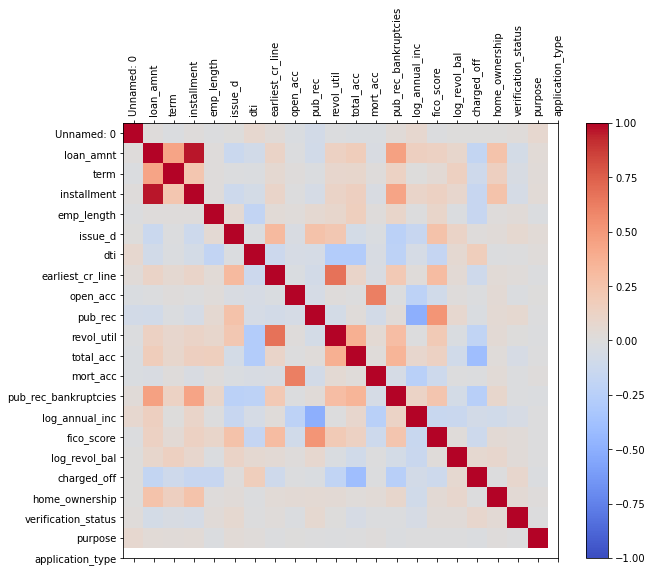

In [234]:
corr = df.corr()
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(df.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(df.columns)
ax.set_yticklabels(df.columns)
plt.show()

In [237]:
col_names = ['loan_amnt','term','installment','dti','open_acc','revol_util','total_acc','mort_acc','pub_rec_bankruptcies','log_annual_inc','fico_score','log_revol_bal','MORTGAGE','OWN','RENT','Not Verified','Source Verified','Verified','charged_off',]
pima = pd.read_excel(r'/Users/andreadentamaro/Downloads/saved_file.xlsx', names=col_names)
pima

,,,,,,,,,,,,,loan_amnt,term,installment,dti,open_acc,revol_util,total_acc,mort_acc,pub_rec_bankruptcies,log_annual_inc,fico_score,log_revol_bal,MORTGAGE,OWN,RENT,Not Verified,Source Verified,Verified,charged_off
6,2500,36,83.03,0,2014-12-01,13.77,2001,9,0,94.3,32,5,0,4.949395,687.0,4.360006,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0
14,6000,36,194.99,10,2014-12-01,6.87,1989,11,0,82.6,48,5,0,5.079185,662.0,4.695718,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0
16,3000,36,97.50,9,2014-12-01,9.54,1995,7,0,42.6,18,0,0,4.778158,682.0,3.693463,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0
27,18450,36,633.36,10,2014-12-01,23.37,2003,11,0,87.0,20,2,0,5.033428,682.0,3.772762,1,1,0,0,1,0,0,0,0,1,0,0,0,1,0
41,5675,36,189.56,2,2014-12-01,15.55,1992,7,0,15.0,15,0,0,4.698979,697.0,3.464936,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1646678,19000,60,583.70,10,2016-01-01,3.91,2007,4,0,49.7,8,1,0,4.698979,687.0,3.655331,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0
1646688,20000,36,637.58,5,2016-01-01,12.80,1999,11,0,56.9,23,2,0,4.986776,717.0,3.876045,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0
1646699,24000,36,781.65,0,2016-01-01,2.18,2001,13,2,33.7,28,10,0,5.176094,702.0,4.107176,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0
1646737,7225,36,237.30,10,2016-01-01,14.44,2001,10,0,76.3,15,2,0,4.740371,692.0,4.399916,1,1,0,0,0,1,0,0,0,1,0,0,0,1,0


In [227]:
# We now combine the two data set  numerical and encoded categorical features into one dataframe
# We use concatenation function

df = pd.concat([numerical, label_encoded_categorical],axis=1)
df.head()

,Unnamed: 0,loan_amnt,term,installment,emp_length,issue_d,dti,earliest_cr_line,open_acc,pub_rec,...,mort_acc,pub_rec_bankruptcies,log_annual_inc,fico_score,log_revol_bal,charged_off,home_ownership,verification_status,purpose,application_type
0,6,2500,36,83.03,0.0,2014-12-01,13.77,2001,9,0,...,5.0,0.0,4.949395,687.0,4.360006,0,0,1,2,0
1,14,6000,36,194.99,10.0,2014-12-01,6.87,1989,11,0,...,5.0,0.0,5.079185,662.0,4.695718,0,0,0,2,0
2,16,3000,36,97.50,9.0,2014-12-01,9.54,1995,7,0,...,0.0,0.0,4.778158,682.0,3.693463,0,2,0,3,0
4,27,18450,36,633.36,10.0,2014-12-01,23.37,2003,11,0,...,2.0,0.0,5.033428,682.0,3.772762,1,0,0,2,0
5,41,5675,36,189.56,2.0,2014-12-01,15.55,1992,7,0,...,0.0,0.0,4.698979,697.0,3.464936,0,2,1,0,0


In [228]:
x = pima.iloc[:,1:-1].values
y = pima.iloc[:,-1].values

In [229]:
X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.30,random_state=0)

In [230]:
#Performing Feature Scaling

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [231]:
# import the class
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X_train,y_train)

#
y_pred=logreg.predict(X_test)

In [232]:
# import the metrics class - confusion matrix evaluation

from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[19084,     0],
       [    0,    98]])

In [233]:
# Apply logit model to determine with features will be used for our model. We will look for p-value less than 0.05

logit_model = sm.Logit(y,x)
result = logit_model.fit()
print(result)

         Current function value: inf
         Iterations: 35


LinAlgError: Singular matrix

In [ ]:
df = pd.concat([df, pd.get_dummies(df['home_ownership'])], axis=1)
df = pd.concat([df, pd.get_dummies(df['verification_status'])], axis=1)
df = pd.concat([df, pd.get_dummies(df['purpose'])], axis=1)
df = pd.concat([df, pd.get_dummies(df['application_type'])], axis=1)
df=df.drop(columns=['home_ownership','verification_status','application_type','purpose'])
df
df.to_excel(r'/Users/andreadentamaro/Downloads/saved_file.xlsx',index=False)

## Correlation Matrix

In [ ]:
corr = df.corr()
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(df.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(df.columns)
ax.set_yticklabels(df.columns)
plt.show()

## LR model

In [ ]:
# LR https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python
#load all necessary libraries
import pandas as pd 
import numpy as np 
import scipy as scp
import sklearn
import statsmodels.api as sm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn import metrics 
from sklearn.metrics import confusion_matrix

#read the dataset
#note that the csv file is space delimited

col_names = ['loan_amnt','term','installment','dti','open_acc','revol_util','total_acc','mort_acc','pub_rec_bankruptcies','log_annual_inc','fico_score','log_revol_bal','MORTGAGE','OWN','RENT','Not Verified','Source Verified','Verified','charged_off',]
pima = pd.read_excel(r'/Users/andreadentamaro/Downloads/saved_file.xlsx', names=col_names)
pima.head()

In [ ]:
#split dataset in features and target variable
feature_cols = ['loan_amnt','term','installment','dti','open_acc','revol_util','total_acc','mort_acc','pub_rec_bankruptcies','log_annual_inc','fico_score','log_revol_bal','MORTGAGE','OWN','RENT','Not Verified','Source Verified','Verified','charged_off']

#X = pima.iloc[:, 1:19].values
#y = pima.iloc[:,0].values
X = pima.iloc[:,1:-1].values
y = pima.iloc[:,-1].values
#X = pima[feature_cols] # Features
#y = pima.charged_off # Target variable

In [ ]:
# split X and y into training and testing sets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.30,random_state=0)

In [ ]:
#Performing Feature Scaling

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
# import the class
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X_train,y_train)

#
y_pred=logreg.predict(X_test)

In [ ]:
# import the metrics class - confusion matrix evaluation

from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

## 